In [1]:
import re
import cv2 
import numpy as np
import pytesseract
from pytesseract import Output
from matplotlib import pyplot as plt

In [2]:
test_image = cv2.imread('/home/nishant/Wipro/work/Dataset/SKU_Identification/Testimage/santoor_technovation/6.color_data39.jpg') 

In [3]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

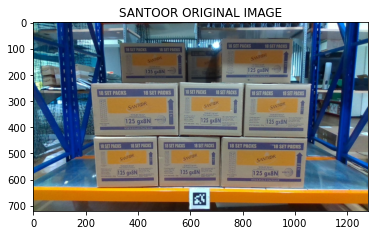

In [4]:
# Plot original image

image = test_image
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.imshow(rgb_img)
plt.title('SANTOOR ORIGINAL IMAGE')
plt.show()

In [5]:
# Preprocess image 

gray = get_grayscale(image)
thresh = thresholding(gray)
opening = opening(gray)
canny = canny(gray)
images = {'gray': gray, 
          'thresh': thresh, 
          'opening': opening, 
          'canny': canny}

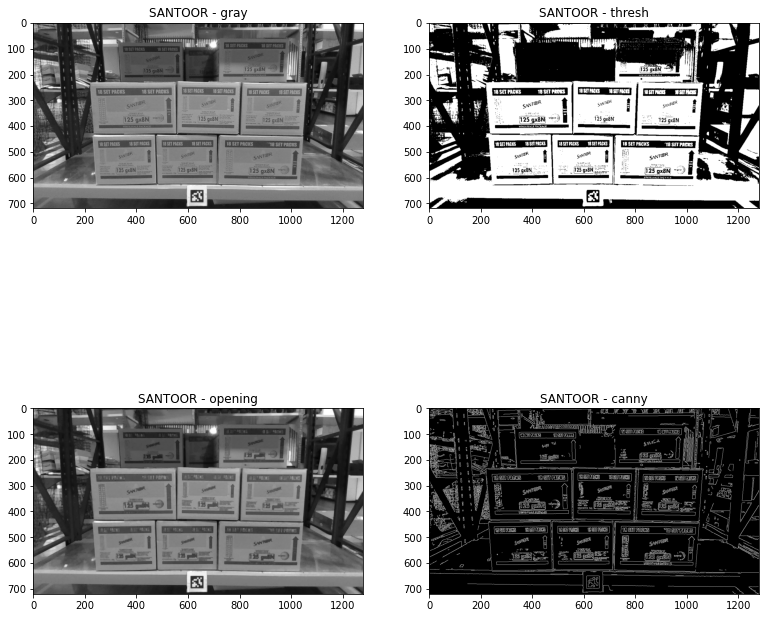

In [6]:
# Plot images after preprocessing

fig = plt.figure(figsize=(13,13))
ax = []

rows = 2
columns = 2
keys = list(images.keys())
for i in range(rows*columns):
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title('SANTOOR - ' + keys[i]) 
    plt.imshow(images[keys[i]], cmap='gray')    

In [7]:
# Get OCR output using Pytesseract

custom_config = r'--oem 3 --psm 6'
print('-----------------------------------------')
print('TESSERACT OUTPUT --> ORIGINAL IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config, lang = 'eng'))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> THRESHOLDED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> OPENED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> CANNY EDGE IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))

-----------------------------------------
TESSERACT OUTPUT --> ORIGINAL IMAGE
-----------------------------------------
——— ete 3 oe ee eae ——E a 2 |
tay in _-
Si = pM r = ee - \ aot
] i a eae oy | : _——“
= — i, 5 \ : —— ! a ae = II i a
a : As | | ; f ia F
iH. a 5 gx8l . (125 g8N ;
| 4 TNT aa ll "
i 3 J i. a Ee = OW oer al mY & a
x? (== EOS | ( | coy
ee iit
mee a e me Ee (125 gx8N) “2? i _ [125 gxBN SE (125 x8N= _ 7
: : _ } TC | Ge | pee Mg y p 7
= oe (UO | Le | CEG . : 7
? fa a z > a
ail || ee) eee -
De ces Sp een Ee ERE pa _
, SS isa | SS ase | 2 as oxen Bl >


-----------------------------------------
TESSERACT OUTPUT --> THRESHOLDED IMAGE
-----------------------------------------
——— ete 3 oe ee eae ——E a 2 |
tay in _-
Si = pM r = ee - \ aot
] i a eae oy | : _——“
= — i, 5 \ : —— ! a ae = II i a
a : As | | ; f ia F
iH. a 5 gx8l . (125 g8N ;
| 4 TNT aa ll "
i 3 J i. a Ee = OW oer al mY & a
x? (== EOS | ( | coy
ee iit
mee a e me Ee (125 gx8N) “2? i _ [125 gxBN SE (125 x8N= _ 7
: : _ 

In [ ]:
# Plot word boxes on image using pytesseract.image_to_data() function

image = image
d = pytesseract.image_to_data(thresh, config=custom_config,output_type=Output.DICT,lang='eng')
print('DATA KEYS: \n', d.keys())

n_boxes = len(d['text'])
for i in range(n_boxes):
    # condition to only pick boxes with a confidence > 60%
    if int(d['conf'][i]) > 0:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE INVOICE WITH WORD LEVEL BOXES')
plt.show()

In [ ]:
# Plot character boxes on image using pytesseract.image_to_boxes() function

image = image
h, w, c = image.shape
boxes = pytesseract.image_to_boxes(image,config=custom_config, lang = 'eng') 
for b in boxes.splitlines():
    b = b.split(' ')
    image = cv2.rectangle(image, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])

plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE INVOICE WITH CHARACTER LEVEL BOXES')
plt.show()

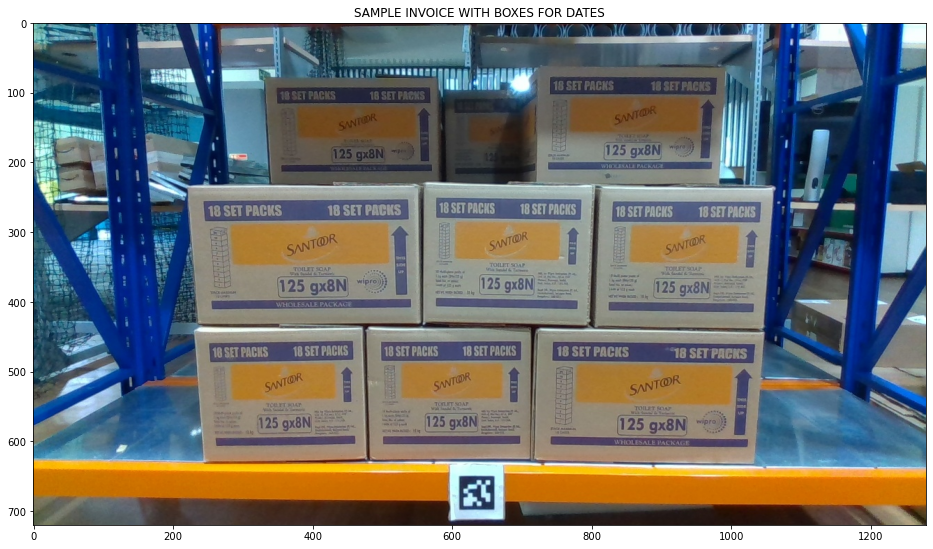

In [10]:
# Plot boxes around text that matches a certain regex template
# In this example we will extract the date from the sample invoice

image = image
d = pytesseract.image_to_data(thresh, config=custom_config,output_type=Output.DICT,lang='eng')

date_pattern = 'SANT'

n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 0:
        if re.match(date_pattern, d['text'][i]):
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE INVOICE WITH BOXES FOR DATES')
plt.show()

In [9]:
d['text']

['',
 '',
 '',
 '',
 ':',
 'seen',
 '7',
 '7',
 're',
 'a',
 'wor',
 'cee',
 'Cala',
 'f',
 '',
 '|',
 'fa',
 '|',
 'a',
 'ia',
 '.',
 'els',
 'os',
 '',
 '4',
 'i"',
 'a',
 'ca',
 'oo',
 ',',
 '',
 'a',
 'a',
 'YW',
 '-',
 '>',
 'is',
 'eae',
 'oF',
 '-_',
 '.',
 '',
 ':',
 ';',
 'i',
 '|',
 'Sine',
 'ad',
 'eer',
 'nN',
 'Vi',
 'at',
 '',
 'lion',
 '|',
 '|',
 'oni',
 '',
 '=',
 'ee',
 'an',
 'i',
 '‘Taal',
 'ry',
 't',
 '125',
 'exdl',
 'a',
 'a)',
 '‘',
 'A',
 '',
 'pon',
 'Eh',
 'Se',
 'a',
 'A',
 '|!',
 '=',
 '',
 'nr',
 'i',
 'a',
 '',
 'eel',
 '10',
 'ST',
 'PACKS',
 'CGI',
 '|',
 'Ue',
 '|',
 'Ce)',
 '',
 '“a',
 '.',
 '_',
 '.',
 '',
 ';',
 'ee',
 'R',
 'aR',
 'pk',
 't',
 '‘',
 '',
 ',',
 '7',
 'sate',
 'san',
 '§',
 'gant',
 'a',
 'ah',
 '',
 'Xf',
 'oe',
 'vue',
 'i',
 'ee',
 '',
 'ee!',
 'oe',
 'ae',
 '(755',
 'yan)',
 'veri',
 '25',
 'ox:',
 'an',
 'ae',
 '',
 'ce)',
 'is',
 '125',
 'gx8Nj',
 '“2',
 '125',
 'gxBN',
 'cay,',
 '125',
 'gx8N',
 '',
 'A',
 'at',
 'DW',
 'SLES